# Votre premier réseau de neurones from scratch
Dans ce notebook vous aller voir comment entrainer votre premier réseau de neurones (RN) pour reconnaitre des chiffres sur une image.

Pour faire simple, le RN ne fera qu'une couche et nous n'utiliserons pas de librairie comme pytorch pour faire l'entrainement.

# Neural network with no hidden layer, all linear and no activation function

In [1]:
# Download the train and test data
!wget "https://github.com/knoel99/MNIST/raw/master/mnist_train.csv.zip"
!wget "https://github.com/knoel99/MNIST/raw/master/mnist_test.csv.zip"

--2025-09-02 10:47:39--  https://github.com/knoel99/MNIST/raw/master/mnist_train.csv.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/knoel99/MNIST/master/mnist_train.csv.zip [following]
--2025-09-02 10:47:39--  https://raw.githubusercontent.com/knoel99/MNIST/master/mnist_train.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13692401 (13M) [application/zip]
Saving to: ‘mnist_train.csv.zip’

mnist_train.csv.zip 100%[===================>]  13.06M  --.-KB/s    in 0.1s    

2025-09-02 10:47:40 (103 MB/s) - ‘mnist_train.csv.zip’ saved [13692401/13692401]

--2025-09-02 10:47:40--  https://g

In [2]:
# unzip
!ls -lh
!unzip  mnist_train.csv.zip
!unzip  mnist_test.csv.zip

total 16M
-rw-r--r-- 1 root root 2.2M Sep  2 10:47 mnist_test.csv.zip
-rw-r--r-- 1 root root  14M Sep  2 10:47 mnist_train.csv.zip
drwxr-xr-x 1 root root 4.0K Aug 28 13:43 sample_data
Archive:  mnist_train.csv.zip
  inflating: mnist_train.csv         
Archive:  mnist_test.csv.zip
  inflating: mnist_test.csv          


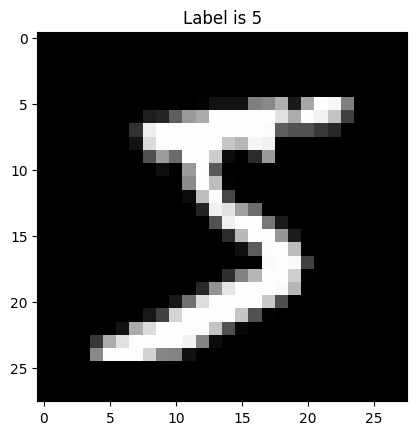

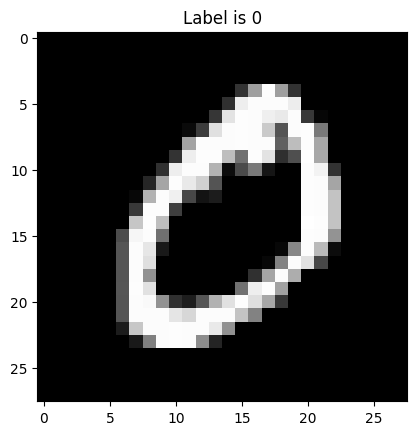

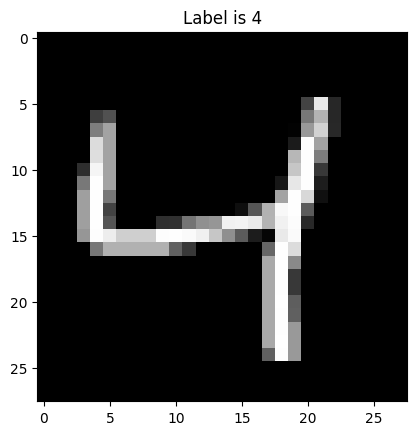

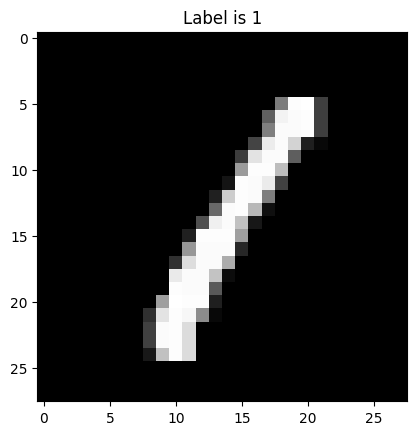

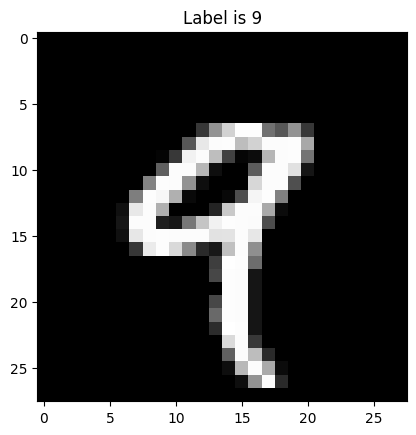

In [3]:
# Let's visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the dataset
# Assuming you've already uploaded the CSV files to your Colab environment
mnist_train_path = 'mnist_train.csv' # Update this path if necessary
mnist_test_path = 'mnist_test.csv'   # Update this path if necessary

train_data = pd.read_csv(mnist_train_path)
test_data = pd.read_csv(mnist_test_path)

# Step 2: Display some of the images and labels
def display_image(data, index):
    """Display an image and its label."""
    # The first column is the label
    label = data.iloc[index, 0]
    # The rest of the columns are pixels
    pixels = data.iloc[index, 1:].values.reshape((28, 28))
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

# Display the first 5 images in the training set
for i in range(5):
    display_image(train_data, i)


In [4]:
# Load the dataset in dataframe

import pandas as pd
import numpy as np

# Load the dataset
mnist_train_path = 'mnist_train.csv' # Update this path if necessary
train_data = pd.read_csv(mnist_train_path)

# Assuming the first column 'label' is the target variable and the rest are features
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values

# Normalize the features to be between 0 and 1
X_train = X_train / 255.0

# Convert y_train to one-hot encoding
def one_hot_encode(y, num_classes):
    """Convert a vector of labels to one-hot encoded format."""
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

y_train = one_hot_encode(y_train, 10) # 10 classes for digits 0-9


In [5]:
import numpy as np

def mean_squared_error(y_true, y_pred):
    """
    Calculate the mean squared error between true labels and predictions.

    Parameters:
    - y_true: np.array, true labels
    - y_pred: np.array, predicted labels

    Returns:
    - mse: float, the mean squared error
    """
    mse = np.mean(np.square(y_true - y_pred))
    return mse

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def identity(x):
    return x

def identity_derivative(x):
    return np.ones_like(x)

class SimpleNeuralNetwork:
    def __init__(self, input_size, output_size, activation='identity'):
        self.weights = 0.01 * np.random.randn(input_size, output_size)
        self.bias = np.zeros((1, output_size))
        # History tracking
        self.weights_history = []
        self.bias_history = []
        self.loss_history = []
        self.epoch_times = []
        self.specific_weights_history = []
        # Set activation function
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative
        elif activation == 'relu':
            self.activation = relu
            self.activation_derivative = relu_derivative
        else: # Default to identity if no recognized activation is provided
            self.activation = identity
            self.activation_derivative = identity_derivative

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.activation(z)

    def train(self, X, y, epochs, learning_rate):
        # Initialize history for specific weights
        pixel_indices = [(9, 9), (9, 14), (9, 19), (14, 9), (14, 14), (14, 19), (19, 9), (19, 14), (19, 19)]
        flattened_indices = [28 * x + y for x, y in pixel_indices]
        for _ in range(len(flattened_indices)):
            self.specific_weights_history.append([])

        for epoch in range(epochs):
            epoch_start_time = time.time()

            # Forward pass
            z = np.dot(X, self.weights) + self.bias
            predictions = self.activation(z)

            # Compute loss (assuming MSE for simplicity)
            loss = np.mean((predictions - y) ** 2)
            self.loss_history.append(loss)

            # Backpropagation
            d_loss = 2 * (predictions - y) / y.size
            d_activation = self.activation_derivative(z)
            d_z = d_loss * d_activation
            d_weights = np.dot(X.T, d_z)
            d_bias = np.sum(d_z, axis=0, keepdims=True)

            # Update parameters
            self.weights -= learning_rate * d_weights
            self.bias -= learning_rate * d_bias

            # Update weights and bias history for visualization
            self.weights_history.append(self.weights[0][0])  # Example: First weight
            self.bias_history.append(self.bias[0][0])  # Example: First bias

            # Record specific weights history
            for i, index in enumerate(flattened_indices):
                self.specific_weights_history[i].append(self.weights[index][0])  # Tracking the first output neuron as an example

            epoch_end_time = time.time()
            self.epoch_times.append(epoch_end_time - epoch_start_time)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}, Time: {(epoch_end_time - epoch_start_time):.4f} seconds")

    def plot_training_insights(self):
        # General Training Insights
        plt.figure(figsize=(12, 6))

        plt.subplot(2, 2, 1)
        plt.plot(self.loss_history)
        plt.title('Loss Evolution')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(2, 2, 2)
        cumulative_time = np.cumsum(self.epoch_times)
        plt.plot(cumulative_time, self.loss_history)
        plt.title('Loss vs. Cumulative Time')
        plt.xlabel('Cumulative Time (s)')
        plt.ylabel('Loss')

        plt.subplot(2, 2, 3)
        plt.plot(self.epoch_times)
        plt.title('Epoch Duration')
        plt.xlabel('Epoch')
        plt.ylabel('Duration (s)')

        plt.subplot(2, 2, 4)
        plt.plot(self.weights_history, label='Weights History')
        plt.plot(self.bias_history, label='Bias History', linestyle='--')
        plt.title('Weights and Bias Evolution')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Plot for Specific Weights
        plt.figure(figsize=(18, 6))
        plot_positions = [(10, 10), (10, 15), (10, 20), (15, 10), (15, 15), (15, 20), (20, 10), (20, 15), (20, 20)]
        for i, position in enumerate(plot_positions):
            plt.subplot(3, 3, i+1)
            plt.plot(self.specific_weights_history[i])
            plt.title(f'Pixel {position[0]}x{position[1]} Weight Evolution')
            plt.xlabel('Epoch')
            plt.ylabel('Weight Value')
        plt.tight_layout()
        plt.show()


In [7]:
nn_identity = SimpleNeuralNetwork(input_size=784, output_size=10, activation='identity')
nn_identity.train(X_train, y_train, epochs=1000, learning_rate=0.01)

Epoch 0, Loss: 0.1100, Time: 0.0620 seconds
Epoch 100, Loss: 0.0693, Time: 0.0511 seconds
Epoch 200, Loss: 0.0597, Time: 0.0749 seconds
Epoch 300, Loss: 0.0550, Time: 0.0508 seconds
Epoch 400, Loss: 0.0522, Time: 0.0566 seconds
Epoch 500, Loss: 0.0504, Time: 0.0506 seconds
Epoch 600, Loss: 0.0491, Time: 0.0512 seconds
Epoch 700, Loss: 0.0481, Time: 0.0508 seconds
Epoch 800, Loss: 0.0473, Time: 0.0510 seconds
Epoch 900, Loss: 0.0467, Time: 0.0509 seconds


In [8]:
nn_sigmoid  = SimpleNeuralNetwork(input_size=784, output_size=10, activation='sigmoid')
nn_sigmoid .train(X_train, y_train, epochs=1000, learning_rate=0.01)

Epoch 0, Loss: 0.2458, Time: 0.0586 seconds
Epoch 100, Loss: 0.1575, Time: 0.0739 seconds
Epoch 200, Loss: 0.1256, Time: 0.0603 seconds
Epoch 300, Loss: 0.1113, Time: 0.0970 seconds
Epoch 400, Loss: 0.1035, Time: 0.0599 seconds
Epoch 500, Loss: 0.0986, Time: 0.1109 seconds
Epoch 600, Loss: 0.0952, Time: 0.0605 seconds
Epoch 700, Loss: 0.0928, Time: 0.0691 seconds
Epoch 800, Loss: 0.0908, Time: 0.0604 seconds
Epoch 900, Loss: 0.0892, Time: 0.0592 seconds


In [9]:
nn_relu     = SimpleNeuralNetwork(input_size=784, output_size=10, activation='relu')
nn_relu    .train(X_train, y_train, epochs=1000, learning_rate=0.01)

Epoch 0, Loss: 0.0970, Time: 0.0577 seconds
Epoch 100, Loss: 0.0723, Time: 0.0556 seconds
Epoch 200, Loss: 0.0609, Time: 0.0558 seconds
Epoch 300, Loss: 0.0544, Time: 0.0722 seconds
Epoch 400, Loss: 0.0493, Time: 0.0560 seconds
Epoch 500, Loss: 0.0448, Time: 0.0562 seconds
Epoch 600, Loss: 0.0419, Time: 0.0672 seconds
Epoch 700, Loss: 0.0397, Time: 0.0564 seconds
Epoch 800, Loss: 0.0379, Time: 0.0939 seconds
Epoch 900, Loss: 0.0365, Time: 0.0563 seconds


In [10]:
import numpy as np

def save_model(model, filename_prefix):
    np.save(f"{filename_prefix}_weights.npy", model.weights)
    np.save(f"{filename_prefix}_biases.npy", model.bias)

# Example usage
#save_model(nn_identity, 'nn_identity')
#save_model(nn_sigmoid, 'nn_sigmoid')
#save_model(nn_relu, 'nn_relu')


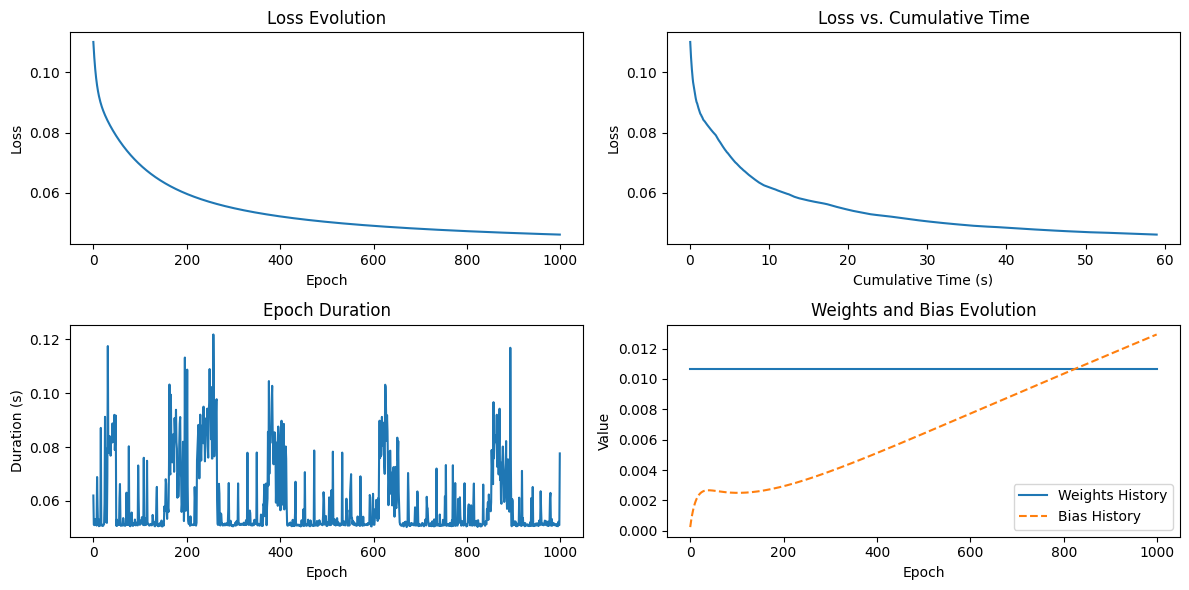

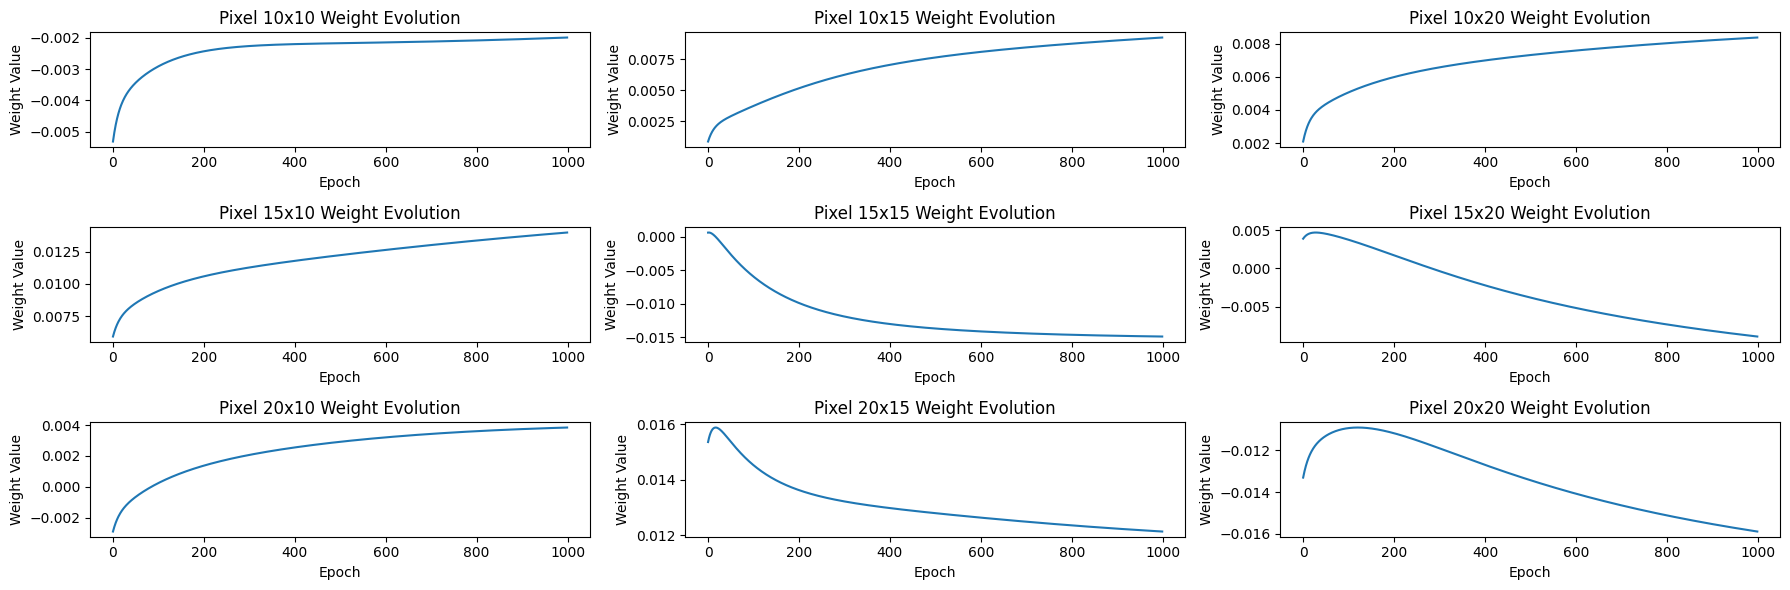

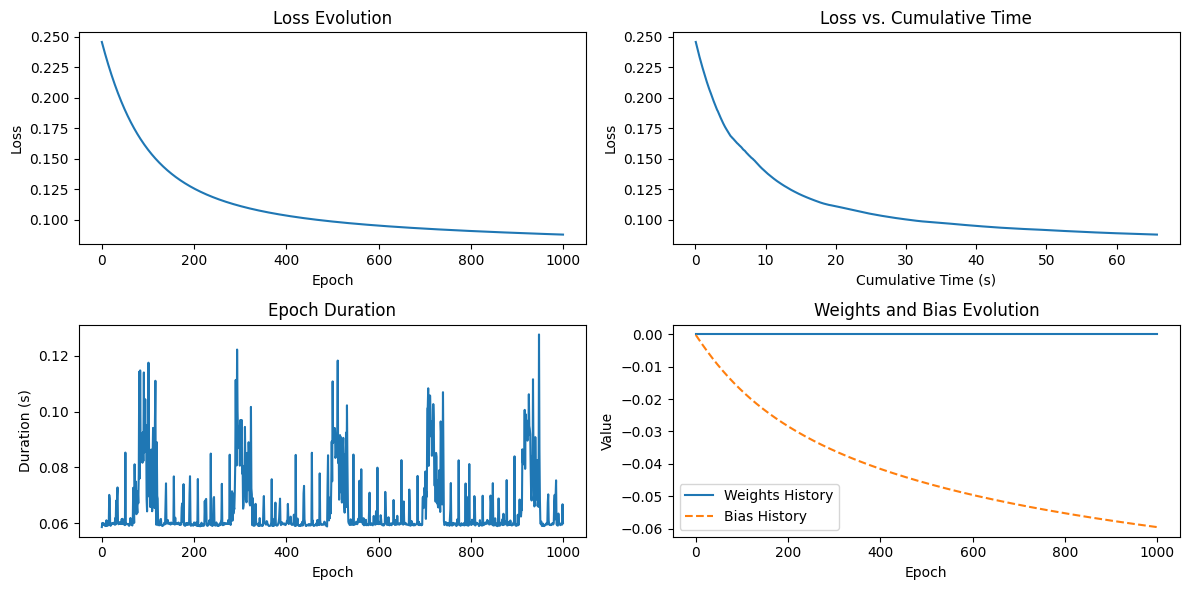

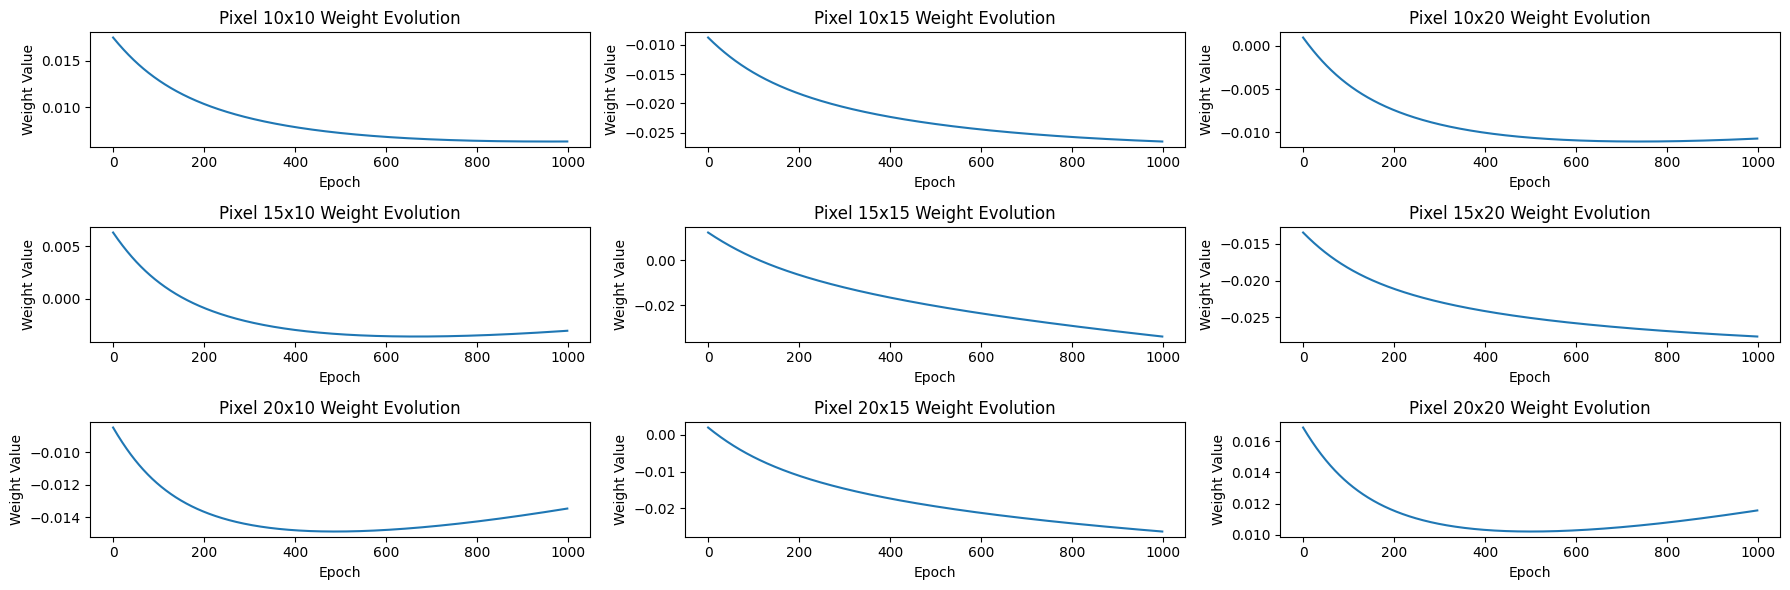

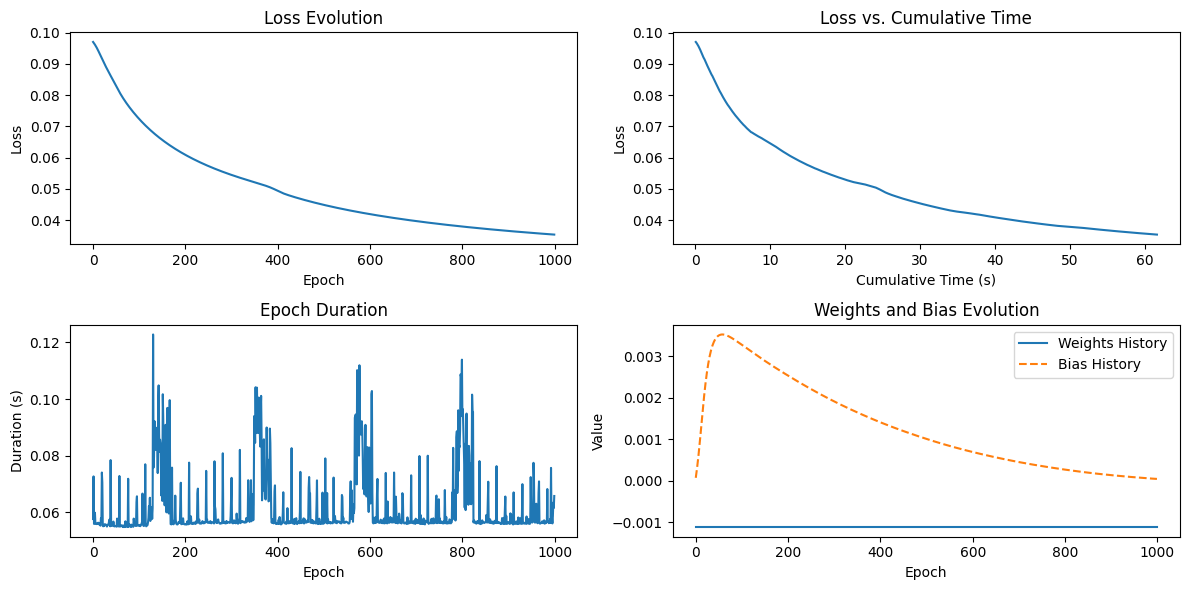

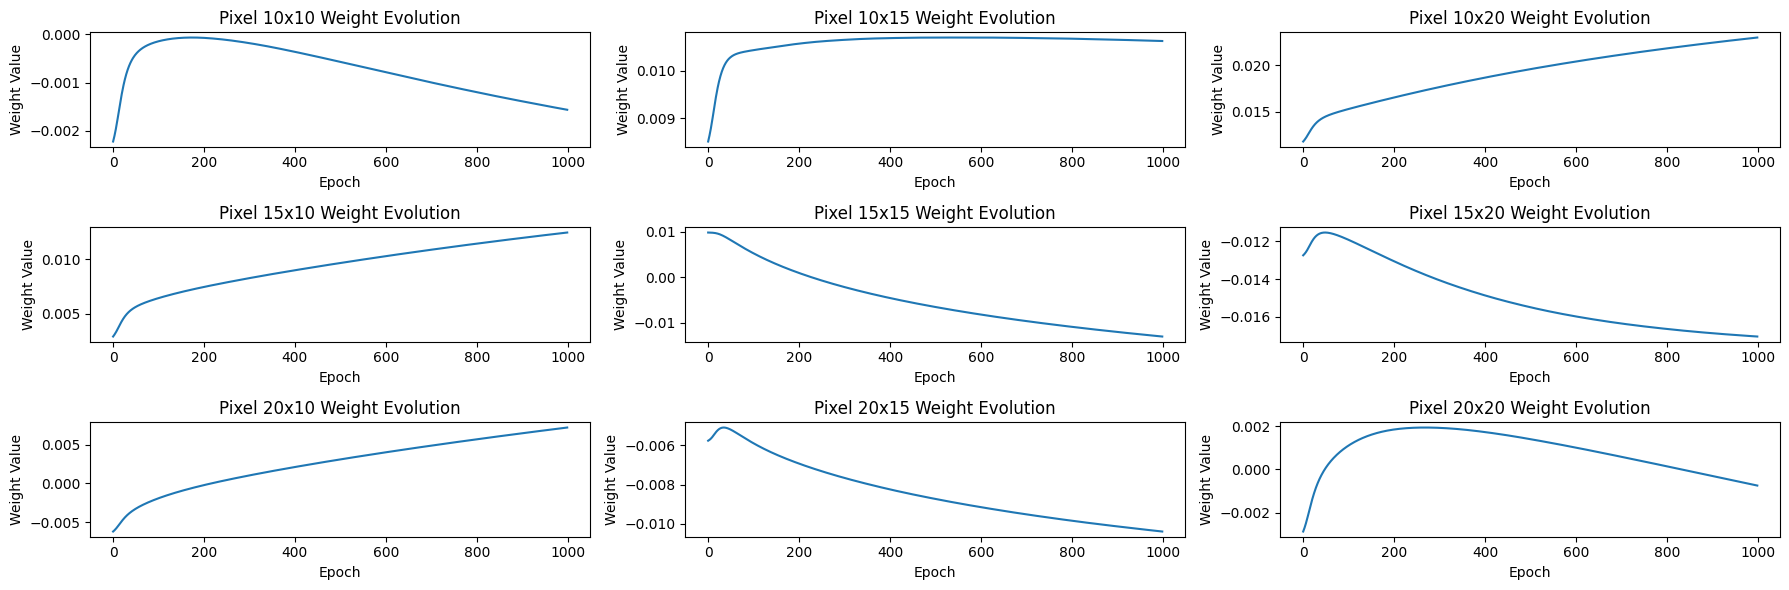

In [11]:
nn_identity.plot_training_insights()
nn_sigmoid .plot_training_insights()
nn_relu    .plot_training_insights()

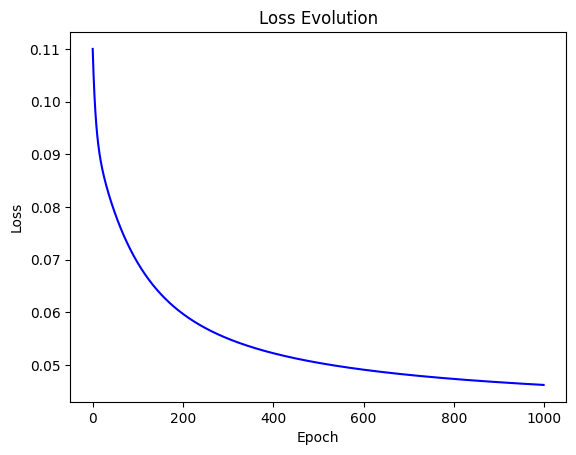

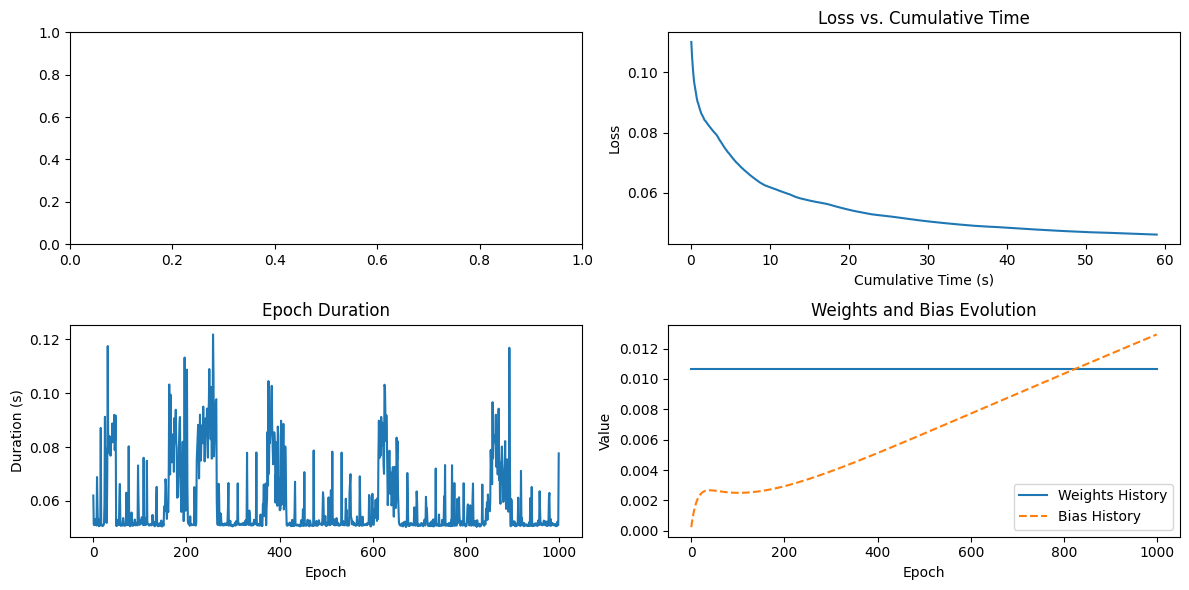

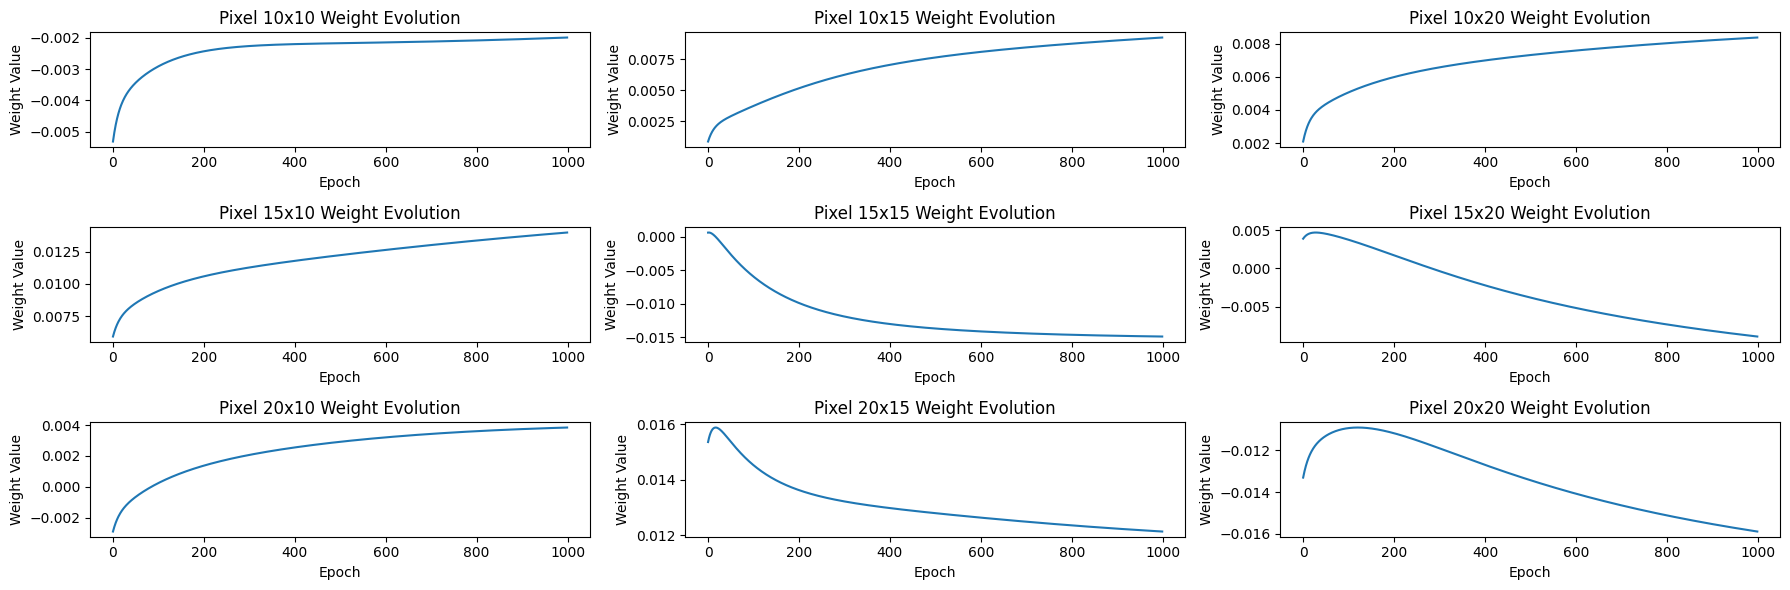

In [12]:
def plot_training_insights2(nn):
  # General Training Insights
  plt.plot(nn.loss_history, color='b')
  plt.title('Loss Evolution')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.figure(figsize=(12, 6))

  plt.subplot(2, 2, 1)


  plt.subplot(2, 2, 2)
  cumulative_time = np.cumsum(nn.epoch_times)
  plt.plot(cumulative_time, nn.loss_history)
  plt.title('Loss vs. Cumulative Time')
  plt.xlabel('Cumulative Time (s)')
  plt.ylabel('Loss')

  plt.subplot(2, 2, 3)
  plt.plot(nn.epoch_times)
  plt.title('Epoch Duration')
  plt.xlabel('Epoch')
  plt.ylabel('Duration (s)')

  plt.subplot(2, 2, 4)
  plt.plot(nn.weights_history, label='Weights History')
  plt.plot(nn.bias_history, label='Bias History', linestyle='--')
  plt.title('Weights and Bias Evolution')
  plt.xlabel('Epoch')
  plt.ylabel('Value')
  plt.legend()

  plt.tight_layout()
  plt.show()

  # Plot for Specific Weights
  plt.figure(figsize=(18, 6))
  plot_positions = [(10, 10), (10, 15), (10, 20), (15, 10), (15, 15), (15, 20), (20, 10), (20, 15), (20, 20)]
  for i, position in enumerate(plot_positions):
      plt.subplot(3, 3, i+1)
      plt.plot(nn.specific_weights_history[i])
      plt.title(f'Pixel {position[0]}x{position[1]} Weight Evolution')
      plt.xlabel('Epoch')
      plt.ylabel('Weight Value')
  plt.tight_layout()
  plt.show()

plot_training_insights2(nn_identity)


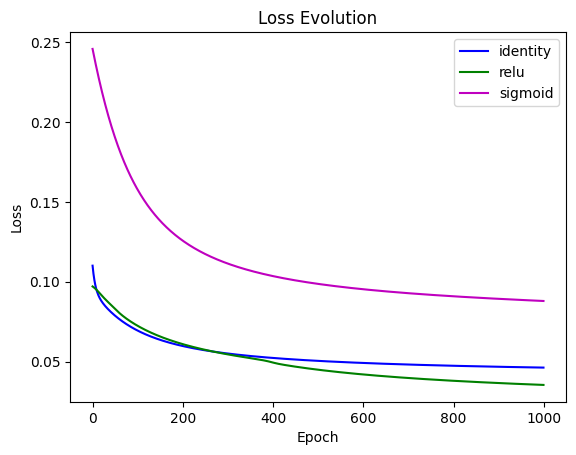

In [13]:
def plot_compare_loss(nn1, nn2, nn3):
  plt.plot(nn1.loss_history, color='b',label='identity')
  plt.plot(nn3.loss_history, color='g',label='relu')
  plt.plot(nn2.loss_history, color='m',label='sigmoid')

  plt.title('Loss Evolution')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

plot_compare_loss(nn_identity, nn_sigmoid, nn_relu)


In [14]:
print(len(nn_identity.loss_history))

1000


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the test data (similar to how you prepared the training data)
mnist_test_path = 'mnist_test.csv' # Update this path if necessary
test_data = pd.read_csv(mnist_test_path)
X_test = test_data.drop('label', axis=1).values / 255.0
y_test = one_hot_encode(test_data['label'].values, 10)


def compute_accuracy(network, X, y):
    correct_predictions = 0
    for i in range(len(X)):
        prediction = network.predict(X[i:i+1])
        predicted_class = np.argmax(prediction)
        true_class = np.argmax(y[i])
        if predicted_class == true_class:
            correct_predictions += 1
    return (correct_predictions / len(X)) * 100


def test_and_plot_accuracy1(nn1, X_train, y_train, X_test, y_test, sota_accuracy=99.7):
    # Compute training set accuracy first
    training_accuracy1 = compute_accuracy(nn1, X_train, y_train)

    correct_predictions1 = 0

    test_accuracy_history1 = []

    for i in range(len(X_test)):
        true_class = np.argmax(y_test[i])

        prediction1 = nn1.predict(X_test[i:i+1])

        predicted_class1 = np.argmax(prediction1)

        if predicted_class1 == true_class:
            correct_predictions1 += 1

        # Current accuracy
        current_accuracy1 = (correct_predictions1 / (i + 1)) * 100

        test_accuracy_history1.append(current_accuracy1)

        # Cumulative average accuracy up to current sample
        cumulative_average_accuracy1 = np.mean(test_accuracy_history1)

    # Plot the accuracy evolution
    plt.figure(figsize=(10, 6))

    plt.plot(test_accuracy_history1, color='b', label='Identity')
    plt.axhline(y=training_accuracy1, color='b', linestyle='--', label=f'Average accuracy Identity ({training_accuracy1:.2f}%)')

    plt.axhline(y=sota_accuracy, color='r', linestyle='-', label=f'SOTA Accuracy ({sota_accuracy}%)')

    plt.title('Accuracy Evolution')
    plt.xlabel('Number of Samples Checked')
    plt.ylabel('Accuracy (%)')
    plt.ylim(50, 100)
    plt.legend(loc='lower right')
    plt.show()


def test_and_plot_accuracy(nn1, nn2, nn3, X_train, y_train, X_test, y_test, sota_accuracy=99.7):
    # Compute training set accuracy first
    training_accuracy1 = compute_accuracy(nn1, X_train, y_train)
    training_accuracy2 = compute_accuracy(nn2, X_train, y_train)
    training_accuracy3 = compute_accuracy(nn3, X_train, y_train)

    correct_predictions1 = 0
    correct_predictions2 = 0
    correct_predictions3 = 0

    test_accuracy_history1 = []
    test_accuracy_history2 = []
    test_accuracy_history3 = []

    for i in range(len(X_test)):
        true_class = np.argmax(y_test[i])

        prediction1 = nn1.predict(X_test[i:i+1])
        prediction2 = nn2.predict(X_test[i:i+1])
        prediction3 = nn3.predict(X_test[i:i+1])

        predicted_class1 = np.argmax(prediction1)
        predicted_class2 = np.argmax(prediction2)
        predicted_class3 = np.argmax(prediction3)

        if predicted_class1 == true_class:
            correct_predictions1 += 1
        if predicted_class2 == true_class:
            correct_predictions2 += 1
        if predicted_class3 == true_class:
            correct_predictions3 += 1

        # Current accuracy
        current_accuracy1 = (correct_predictions1 / (i + 1)) * 100
        current_accuracy2 = (correct_predictions2 / (i + 1)) * 100
        current_accuracy3 = (correct_predictions3 / (i + 1)) * 100

        test_accuracy_history1.append(current_accuracy1)
        test_accuracy_history2.append(current_accuracy2)
        test_accuracy_history3.append(current_accuracy3)

    # Plot the accuracy evolution
    plt.figure(figsize=(10, 6))

    plt.plot(test_accuracy_history1, color='b', label='Identity')
    plt.plot(test_accuracy_history2, color='g', label='Relu')
    plt.plot(test_accuracy_history3, color='m', label='Sigmoid')

    plt.axhline(y=training_accuracy1, color='b', linestyle='--', label=f'Average accuracy Identity ({training_accuracy1:.2f}%)')
    plt.axhline(y=training_accuracy2, color='g', linestyle='--', label=f'Average accuracy Relu ({training_accuracy2:.2f}%)')
    plt.axhline(y=training_accuracy3, color='m', linestyle='--', label=f'Average accuracy Sigmoid ({training_accuracy3:.2f}%)')

    plt.axhline(y=sota_accuracy, color='r', linestyle='-', label=f'SOTA Accuracy ({sota_accuracy}%)')

    plt.title('Accuracy Evolution')
    plt.xlabel('Number of Samples Checked')
    plt.ylabel('Accuracy (%)')
    plt.ylim(50, 100)
    plt.legend(loc='lower right')
    plt.show()

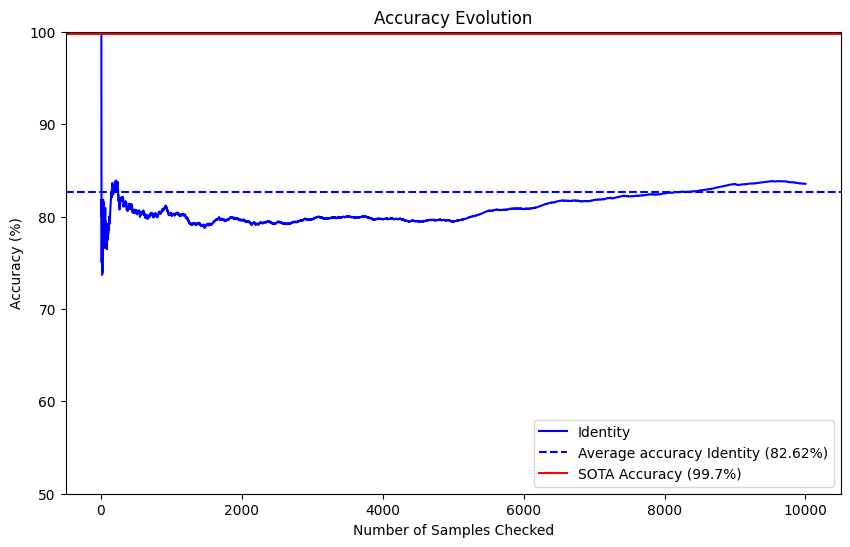

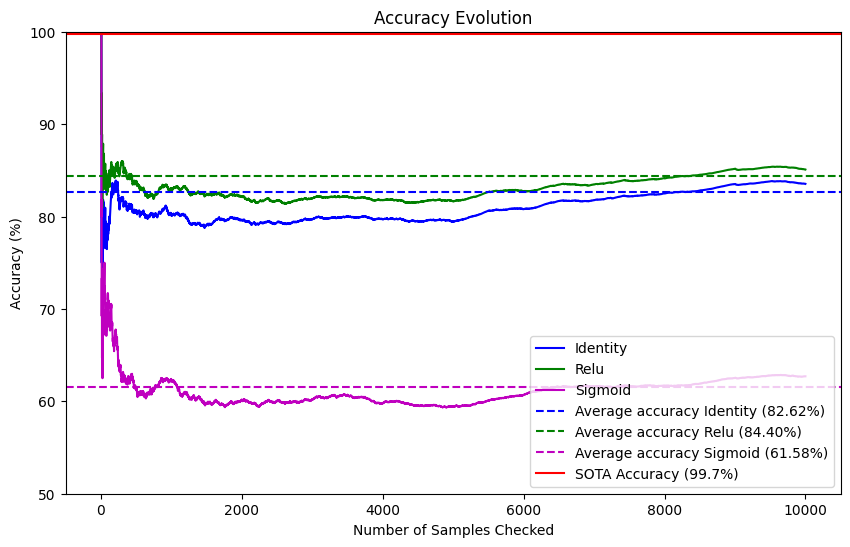

In [16]:
test_and_plot_accuracy1(nn_identity, X_train, y_train, X_test, y_test)
test_and_plot_accuracy(nn_identity, nn_relu, nn_sigmoid, X_train, y_train, X_test, y_test)


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(X, y, indices, title, predictions=None, convert=True):
    """Plot a selection of images, their labels, and model predictions.

    Parameters:
    - X: The images.
    - y: The true labels.
    - indices: Indices of the images to plot.
    - title: Title for the plots.
    - predictions: The predicted labels for the provided indices.
    - convert: Boolean indicating if images need reshaping.
    """
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(indices[:5]):  # Plot up to 5 images from provided indices
        plt.subplot(1, 5, i + 1)
        img = X[idx].reshape(28, 28) if convert else X[idx]
        plt.imshow(img, cmap='gray')

        pred_text = f"Pred: {predictions[i]}" if predictions is not None else ""
        true_text = f"True: {np.argmax(y[idx])}"
        plt.title(f"{pred_text}\n{true_text}", fontsize=20, pad=5)
        plt.axis('off')

    plt.suptitle(title, fontsize=24, y=1.05)  # Adjust y parameter to lift the suptitle
    plt.tight_layout(pad=2.0)
    plt.show()


def evaluate_and_plot_samples(network, X_test, y_test):
    correct_indices = []
    incorrect_indices = []
    predictions = []

    for i in range(len(X_test)):
        prediction_vector = network.predict(X_test[i:i+1])
        predicted_class = np.argmax(prediction_vector)
        true_class = np.argmax(y_test[i])
        predictions.append(predicted_class)

        if predicted_class == true_class:
            #print("i = " + str(i) + " predicted_class=" + str(predicted_class) + " true_class= " + str(true_class))
            correct_indices.append(i)
        else:
            incorrect_indices.append(i)

        if len(correct_indices) >= 5 and len(incorrect_indices) >= 5:
            break

    # Extract predictions for correctly and incorrectly classified images
    correct_predictions = [predictions[i] for i in correct_indices]
    incorrect_predictions = [predictions[i] for i in incorrect_indices]

    # Plot correctly classified images with corresponding predictions
    plot_images(X_test, y_test, correct_indices, "Correctly Classified", [predictions[i] for i in correct_indices])

    # Plot incorrectly classified images with corresponding predictions
    plot_images(X_test, y_test, incorrect_indices, "Incorrectly Classified", [predictions[i] for i in incorrect_indices])


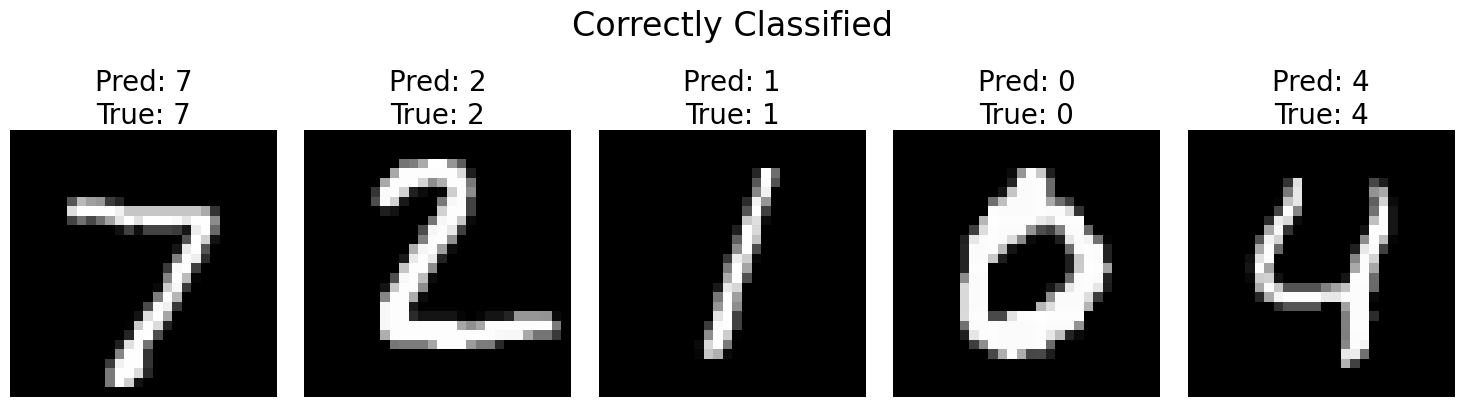

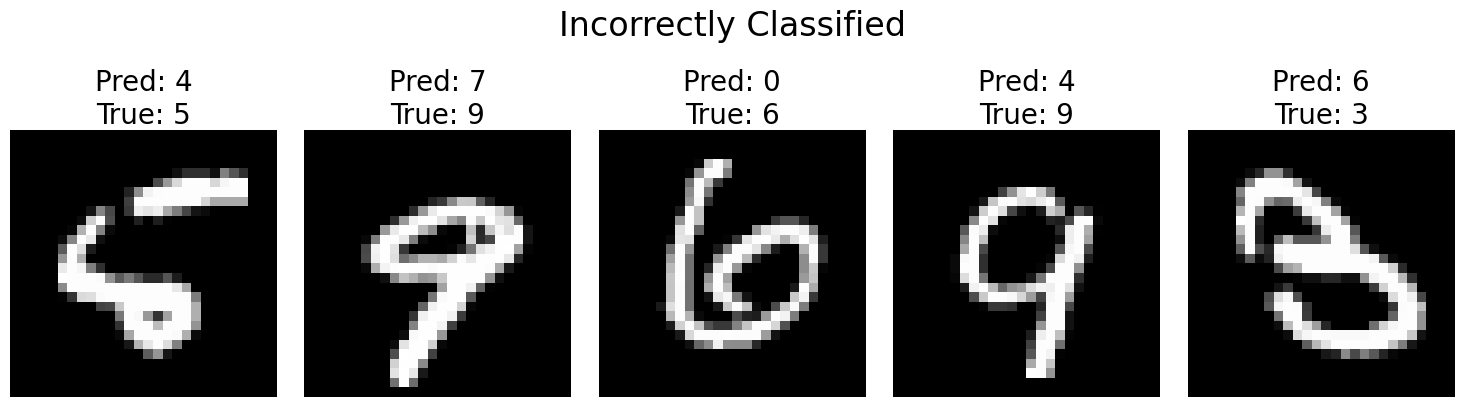

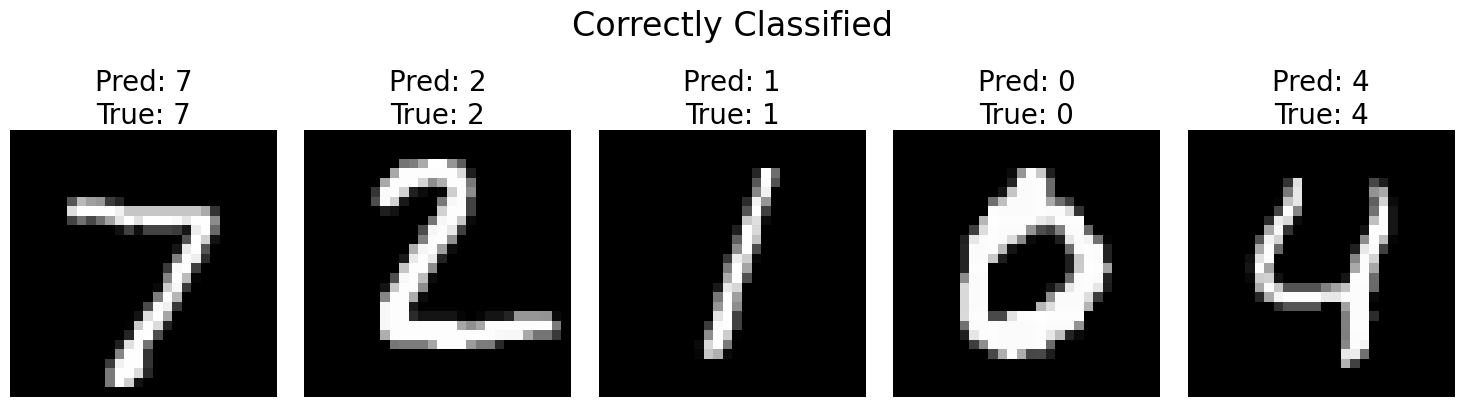

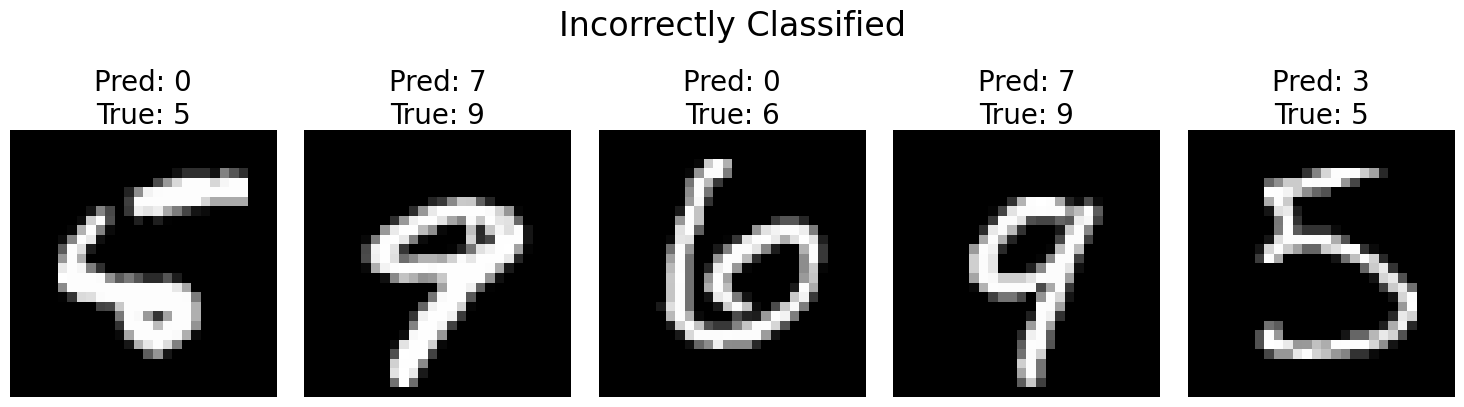

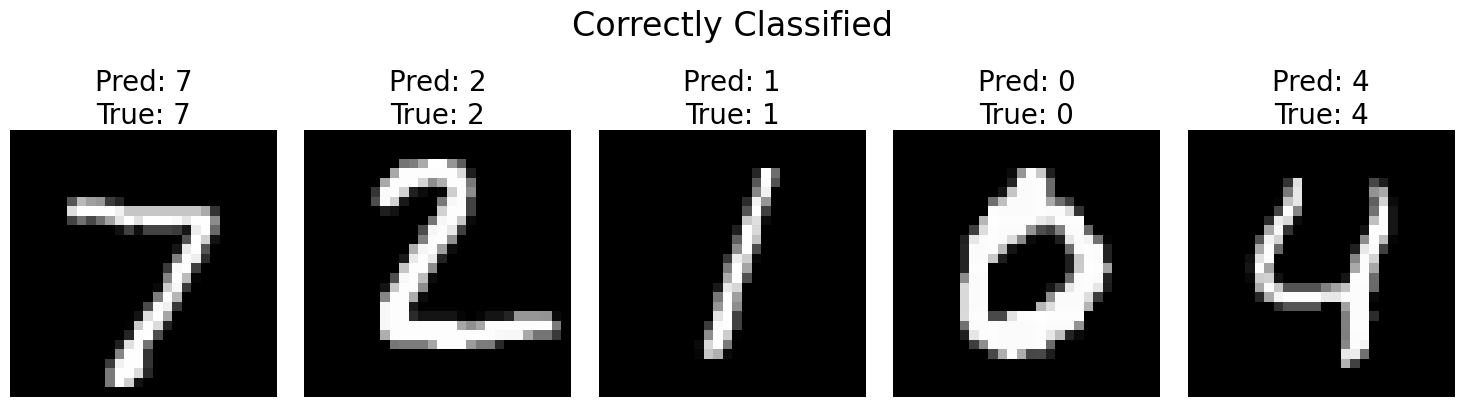

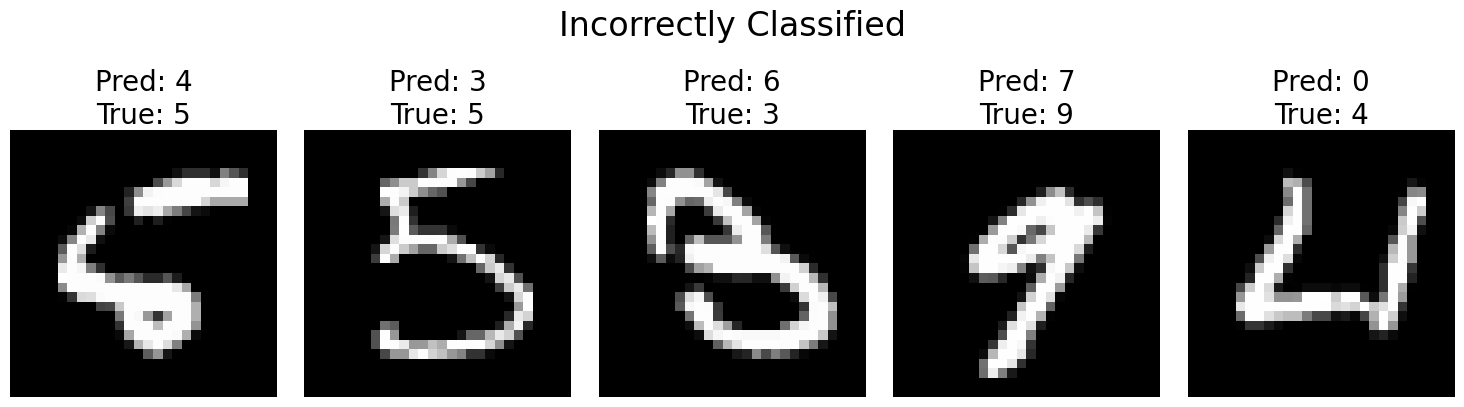

In [18]:
# Assuming X_test and y_test are prepared and network is your trained model
evaluate_and_plot_samples(nn_identity, X_test, y_test)
evaluate_and_plot_samples(nn_sigmoid , X_test, y_test)
evaluate_and_plot_samples(nn_relu    , X_test, y_test)


In [19]:
# Modifier aussi le type d'exécution pour pouvoir utiliser une carte graphique Nvidia T4
!apt install nvidia-cuda-toolkit

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libaccinj64-11.5 libatk-wrapper-java
  libatk-wrapper-java-jni libbabeltrace1 libcub-dev libcublas11 libcublaslt11
  libcudart11.0 libcufft10 libcufftw10 libcuinj64-11.5 libcupti-dev
  libcupti-doc libcupti11.5 libcurand10 libcusolver11 libcusolvermg11
  libcusparse11 libdebuginfod-common libdebuginfod1 libegl-dev libgail-common
  libgail18 libgl-dev libgl1-mesa-dev libgles-dev libgles1 libglvnd-core-dev
  libglvnd-dev libglx-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libipt2
  libnppc11 libnppial11 libnppicc11 libnppidei11 libnppif11 libnppig11
  libnppim11 libnppist11 libnppisu11 libnppitc11 libnpps11 libnvblas11
  libnvidia-compute-495 libnvidia-compute-510 libnvidia-compute-535
  libnvidia-ml-dev libnvjpeg11 libnvrtc-builtins11.5 libnvrtc11.2
  libnvtoolsext1 libnvvm4 libopengl-dev librsvg2-c

In [20]:
import cupy as cp

class SimpleNeuralNetworkGPU:
    def __init__(self, input_size, output_size, activation='identity'):
        # Initialize weights and biases with CuPy arrays for GPU computation
        self.weights = cp.random.randn(input_size, output_size) * 0.01
        self.bias = cp.zeros((1, output_size))
        self.set_activation_function(activation)
        # History tracking
        self.weights_history = []
        self.bias_history = []
        self.loss_history = []
        self.epoch_times = []
        self.specific_weights_history = []

    def set_activation_function(self, activation):
        # Define activation functions and their derivatives using CuPy
        if activation == 'sigmoid':
            self.activation = lambda x: 1 / (1 + cp.exp(-x))
            self.activation_derivative = lambda x: self.activation(x) * (1 - self.activation(x))
        elif activation == 'relu':
            self.activation = lambda x: cp.maximum(0, x)
            self.activation_derivative = lambda x: cp.where(x > 0, 1, 0)
        else:  # Defaults to identity function
            self.activation = lambda x: x
            self.activation_derivative = lambda x: cp.ones_like(x)

    def predict(self, X):
        # Ensure X is a CuPy array
        X_gpu = cp.asarray(X)
        z = cp.dot(X_gpu, self.weights) + self.bias
        return self.activation(z)

    def train(self, X, y, epochs, learning_rate):
        X_gpu = cp.asarray(X)
        y_gpu = cp.asarray(y)

        # Initialize history for specific weights
        pixel_indices = [(9, 9), (9, 14), (9, 19), (14, 9), (14, 14), (14, 19), (19, 9), (19, 14), (19, 19)]
        flattened_indices = [28 * x + y for x, y in pixel_indices]

        for _ in range(len(flattened_indices)):
            self.specific_weights_history.append([])

        for epoch in range(epochs):
            epoch_start_time = time.time()

            # Forward pass
            z = cp.dot(X_gpu, self.weights) + self.bias
            predictions = self.activation(z)

            # Compute loss using CuPy
            loss = cp.mean((predictions - y_gpu) ** 2)
            self.loss_history.append(loss)

            # Backpropagation to compute gradients using CuPy
            d_loss = 2 * (predictions - y_gpu) / y_gpu.size
            d_activation = self.activation_derivative(z)
            d_z = d_loss * d_activation
            d_weights = cp.dot(X_gpu.T, d_z)
            d_bias = cp.sum(d_z, axis=0, keepdims=True)

            # Update parameters
            self.weights -= learning_rate * d_weights
            self.bias -= learning_rate * d_bias

            # Update weights and bias history for visualization
            self.weights_history.append(self.weights[0][0])  # Example: First weight
            self.bias_history.append(self.bias[0][0])  # Example: First bias

            # Record specific weights history
            for i, index in enumerate(flattened_indices):
                self.specific_weights_history[i].append(self.weights[index][0])  # Tracking the first output neuron as an example

            epoch_end_time = time.time()
            self.epoch_times.append(epoch_end_time - epoch_start_time)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}, Time: {(epoch_end_time - epoch_start_time):.4f} seconds")

    def plot_training_insights(self):
        # General Training Insights
        plt.figure(figsize=(12, 6))

        plt.subplot(2, 2, 1)
        plt.plot(self.loss_history)
        plt.title('Loss Evolution')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(2, 2, 2)
        cumulative_time = np.cumsum(self.epoch_times)
        plt.plot(cumulative_time, self.loss_history)
        plt.title('Loss vs. Cumulative Time')
        plt.xlabel('Cumulative Time (s)')
        plt.ylabel('Loss')

        plt.subplot(2, 2, 3)
        plt.plot(self.epoch_times)
        plt.title('Epoch Duration')
        plt.xlabel('Epoch')
        plt.ylabel('Duration (s)')

        plt.subplot(2, 2, 4)
        plt.plot(self.weights_history, label='Weights History')
        plt.plot(self.bias_history, label='Bias History', linestyle='--')
        plt.title('Weights and Bias Evolution')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Plot for Specific Weights
        plt.figure(figsize=(18, 6))
        plot_positions = [(10, 10), (10, 15), (10, 20), (15, 10), (15, 15), (15, 20), (20, 10), (20, 15), (20, 20)]
        for i, position in enumerate(plot_positions):
            plt.subplot(3, 3, i+1)
            plt.plot(self.specific_weights_history[i])
            plt.title(f'Pixel {position[0]}x{position[1]} Weight Evolution')
            plt.xlabel('Epoch')
            plt.ylabel('Weight Value')
        plt.tight_layout()
        plt.show()


In [21]:
nn_identityGPU = SimpleNeuralNetworkGPU(input_size=784, output_size=10, activation='identity')
nn_identityGPU.train(X_train, y_train, epochs=1000, learning_rate=0.01)

Epoch 0, Loss: 0.1099, Time: 1.6355 seconds
Epoch 100, Loss: 0.0703, Time: 0.0008 seconds
Epoch 200, Loss: 0.0600, Time: 0.0008 seconds
Epoch 300, Loss: 0.0552, Time: 0.0007 seconds
Epoch 400, Loss: 0.0524, Time: 0.0008 seconds
Epoch 500, Loss: 0.0505, Time: 0.0007 seconds
Epoch 600, Loss: 0.0492, Time: 0.0008 seconds
Epoch 700, Loss: 0.0482, Time: 0.0008 seconds
Epoch 800, Loss: 0.0474, Time: 0.0008 seconds
Epoch 900, Loss: 0.0468, Time: 0.0008 seconds


In [22]:
nn_sigmoidGPU = SimpleNeuralNetworkGPU(input_size=784, output_size=10, activation='sigmoid')
nn_sigmoidGPU.train(X_train, y_train, epochs=1000, learning_rate=0.01)

Epoch 0, Loss: 0.2516, Time: 0.4952 seconds
Epoch 100, Loss: 0.1595, Time: 0.0010 seconds
Epoch 200, Loss: 0.1264, Time: 0.0011 seconds
Epoch 300, Loss: 0.1116, Time: 0.0010 seconds
Epoch 400, Loss: 0.1036, Time: 0.0010 seconds
Epoch 500, Loss: 0.0986, Time: 0.0010 seconds
Epoch 600, Loss: 0.0952, Time: 0.0010 seconds
Epoch 700, Loss: 0.0927, Time: 0.0010 seconds
Epoch 800, Loss: 0.0907, Time: 0.0010 seconds
Epoch 900, Loss: 0.0891, Time: 0.0010 seconds


In [23]:
nn_reluGPU = SimpleNeuralNetworkGPU(input_size=784, output_size=10, activation='relu')
nn_reluGPU.train(X_train, y_train, epochs=1000, learning_rate=0.01)

Epoch 0, Loss: 0.0958, Time: 0.4847 seconds
Epoch 100, Loss: 0.0686, Time: 0.0008 seconds
Epoch 200, Loss: 0.0569, Time: 0.0010 seconds
Epoch 300, Loss: 0.0502, Time: 0.0008 seconds
Epoch 400, Loss: 0.0459, Time: 0.0009 seconds
Epoch 500, Loss: 0.0428, Time: 0.0008 seconds
Epoch 600, Loss: 0.0404, Time: 0.0009 seconds
Epoch 700, Loss: 0.0385, Time: 0.0008 seconds
Epoch 800, Loss: 0.0370, Time: 0.0017 seconds
Epoch 900, Loss: 0.0358, Time: 0.0009 seconds


In [24]:
def plot_compare_loss_time(nn1, nn2, title):
    print(type(nn1.epoch_times))
    print(type(nn2.epoch_times))

    print(type(nn1.loss_history))
    print(type(nn2.loss_history))

    cumulative_time1 = np.cumsum(np.array(nn1.epoch_times))
    cumulative_time2 = np.cumsum(np.array(nn2.epoch_times))

    loss_history1 = np.array(nn1.loss_history)
    loss_history2 = np.array(nn2.loss_history)

    plt.plot(cumulative_time1, loss_history1, label='CPU')
    plt.plot(cumulative_time2, loss_history2, label='GPU')
    plt.title('Loss Evolution for ' + title)
    plt.xlabel('Cumulative Time (s)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


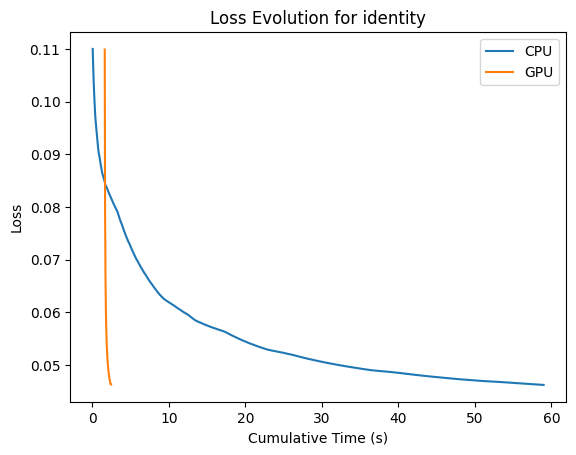

In [25]:
# Example of explicitly converting a CuPy array to a NumPy array before plotting
if isinstance(nn_identityGPU.loss_history[0], cp.ndarray):
    nn_identityGPU.loss_history = [cp_item.get() for cp_item in nn_identityGPU.loss_history]

if isinstance(nn_identityGPU.epoch_times[0], cp.ndarray):
    nn_identityGPU.epoch_times = [cp_item.get() for cp_item in nn_identityGPU.epoch_times]

plot_compare_loss_time(nn_identity, nn_identityGPU, "identity")

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


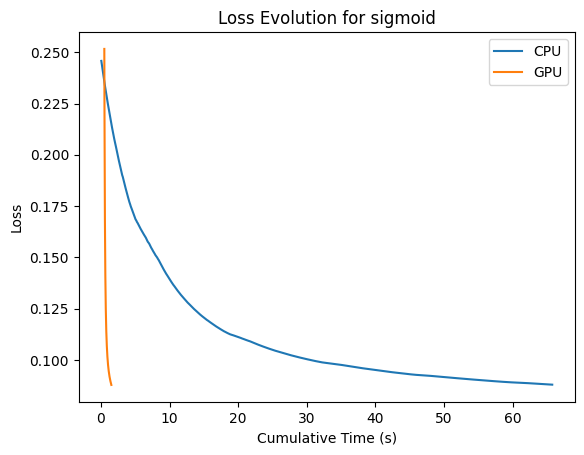

In [26]:
# Example of explicitly converting a CuPy array to a NumPy array before plotting
if isinstance(nn_sigmoidGPU.loss_history[0], cp.ndarray):
    nn_sigmoidGPU.loss_history = [cp_item.get() for cp_item in nn_sigmoidGPU.loss_history]

if isinstance(nn_sigmoidGPU.epoch_times[0], cp.ndarray):
    nn_sigmoidGPU.epoch_times = [cp_item.get() for cp_item in nn_sigmoidGPU.epoch_times]

plot_compare_loss_time(nn_sigmoid, nn_sigmoidGPU, "sigmoid")

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


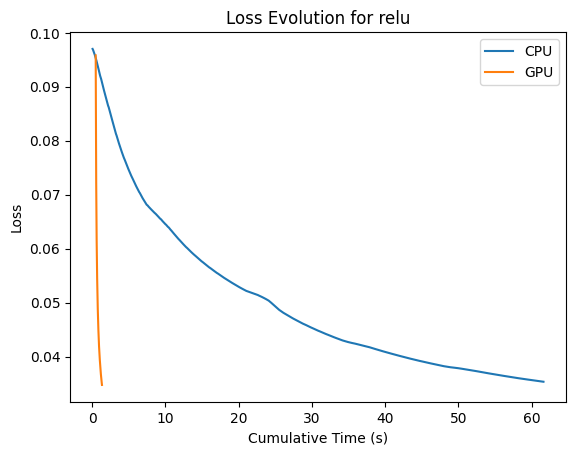

In [27]:
# Example of explicitly converting a CuPy array to a NumPy array before plotting
if isinstance(nn_reluGPU.loss_history[0], cp.ndarray):
    nn_reluGPU.loss_history = [cp_item.get() for cp_item in nn_reluGPU.loss_history]

if isinstance(nn_reluGPU.epoch_times[0], cp.ndarray):
    nn_reluGPU.epoch_times = [cp_item.get() for cp_item in nn_reluGPU.epoch_times]

plot_compare_loss_time(nn_relu, nn_reluGPU, "relu")

In [28]:
def minsec(total_seconds):
  minutes = total_seconds // 60  # Get the whole minutes
  seconds = total_seconds % 60   # Get the remaining seconds

  print(f"{minutes} minute(s) and {seconds} second(s)")



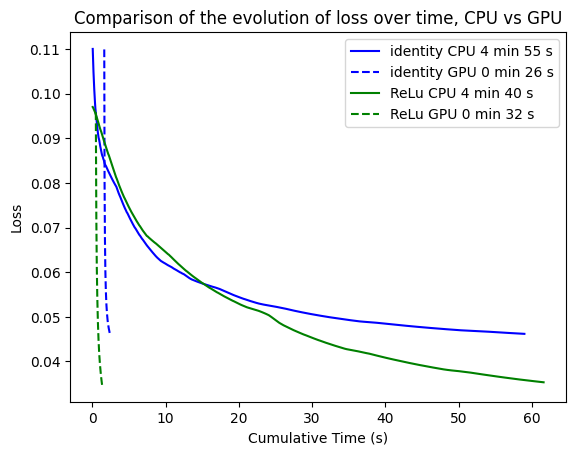

In [29]:
def plot_compare_loss_time2(nn1, nn2, nn3, nn4):
    cumulative_time1 = np.cumsum(np.array(nn1.epoch_times))
    cumulative_time2 = np.cumsum(np.array(nn2.epoch_times))
    cumulative_time3 = np.cumsum(np.array(nn3.epoch_times))
    cumulative_time4 = np.cumsum(np.array(nn4.epoch_times))

    #minsec(cumulative_time1[len(cumulative_time1)-1])
    #minsec(cumulative_time2[len(cumulative_time2)-1])
    #minsec(cumulative_time3[len(cumulative_time3)-1])
    #minsec(cumulative_time4[len(cumulative_time4)-1])

    loss_history1 = np.array(nn1.loss_history)
    loss_history2 = np.array(nn2.loss_history)
    loss_history3 = np.array(nn3.loss_history)
    loss_history4 = np.array(nn4.loss_history)

    plt.plot(cumulative_time1, loss_history1, color='b', linestyle='-', label='identity CPU 4 min 55 s')
    plt.plot(cumulative_time2, loss_history2, color='b', linestyle='--',label='identity GPU 0 min 26 s')
    plt.plot(cumulative_time3, loss_history3, color='g', linestyle='-', label='ReLu CPU 4 min 40 s')
    plt.plot(cumulative_time4, loss_history4, color='g', linestyle='--',label='ReLu GPU 0 min 32 s')

    plt.title('Comparison of the evolution of loss over time, CPU vs GPU')
    plt.xlabel('Cumulative Time (s)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_compare_loss_time2(nn_identity, nn_identityGPU, nn_relu, nn_reluGPU)